In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours

# EacyOCR 사용하기
from easyocr import Reader
from PIL import ImageFont, ImageDraw, Image

In [2]:
languages_list = ['en', 'ko']
gpu = True
font = './OCR_with_Python/Fonts/NanumSquareR.ttf'

In [3]:
def display(img, cmap='gray'):
    # fig = plt.figure(figsize=(11.69,8.27)) # A4 사이즈
    fig = plt.figure(figsize=(16.53, 11.69))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

# Threshholding
def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return thresh

# Normalization
def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis = -1)
    return img

# Resizing
# 이미지의 사이즈를 28x28로 만들고 정사각형이 아닌경우
# 이미지를 중앙정렬 한 다음에 남는 공간을 검은색 배경으로 채움.
def resizing(img, w, h):
    if w > h:
        resized = imutils.resize(img, width=28)
    else:
        resized = imutils.resize(img, height=28)
    
    (h, w) = resized.shape
    dx = int(max(0, 28 - w) / 2.0)  # 남는 공간(X축) 계산 식
    dy = int(max(0, 28 - h) / 2.0)  # 남는 공간(Y축) 계산 식

    filled = cv2.copyMakeBorder(resized, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    filled = cv2.resize(filled, (28, 28))

    return filled

def extract_roi(img, margin = 2):
    roi = img[y - margin:y+h, x - margin:x + w + margin]
    return roi

# Contour Derection
def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]
    return conts


def preprocess_img(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray_img, (3, 3), 7)
    # edges = cv2.Canny(blur, 40, 150)
    # dilation = cv2.dilate(edges, np.ones((3, 3)))

    return gray_img, dilation

def prediction(predict, character_list):
    i = np.argmax(predict)
    probability = predict[i]
    character = character_list[i]

    return i, probability, character

def draw_box(copied_img, character, x, y, w, h):
    cv2.rectangle(copied_img, (x, y), (x + w, y + h), (255, 100, 0), 2)
    cv2.putText(copied_img, character, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 2)

def process_box(gray, x, y, w, h):
    roi = extract_roi(gray)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resizing(thresh, w, h)
    plt.imshow(resized, cmap='gray')
    plt.show()
    normalized = normalization(resized)
    return (normalized, (x, y, w, h))
    # characters.append((normalized, (x, y, w, h)))

def write_text(img, text, x, y, font, color=(50, 50, 255), font_size=70):
    font = ImageFont.truetype(font, font_size)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)
    draw.text((x, y - font_size), text, font = font, fill=color)
    img = np.array(img_pil)
    return img

# Bouding Box
#   - lt: left top
#   - rt: right top
#   - br: bottom right
#   - bl: bottom left
def box_coordinates(box):
    (lt, rt, br, bl) = box
    lt = (int(lt[0]), int(lt[1]))
    rt = (int(rt[0]), int(rt[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    return lt, rt, br, bl

def draw_img(img, lt, br, color=(0, 255, 200), thickness=2):
    cv2.rectangle(img, lt, br, color, thickness)
    return img

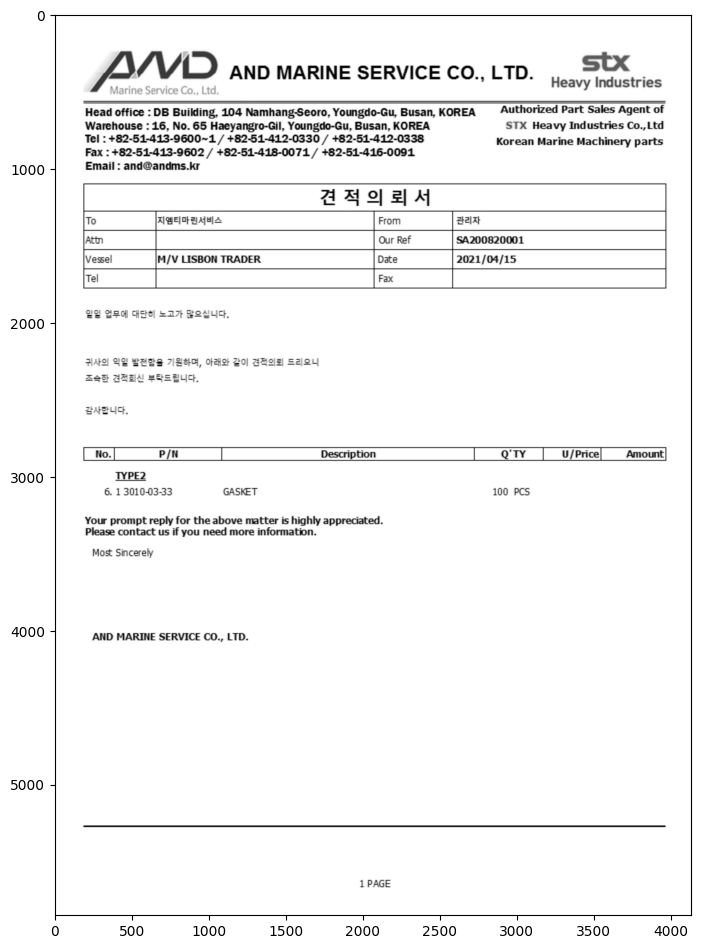

In [4]:
# Loading the Test Image
img = cv2.imread('./OCR_with_Python/Pdfs/IMGAND_SA200820001_REQ.0.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(gray_img)


In [5]:

gray_img, processed_img = preprocess_img(img)
display(processed_img)

NameError: name 'dilation' is not defined

In [ ]:
reader = Reader(languages_list, gpu)
results = reader.readtext(processed_img)

In [ ]:
img_copy = img.copy()

for (box, text, probability) in results:
    print(box, text, probability)
    lt, rt, br, bl = box_coordinates(box)
    img_copy = draw_img(img_copy, lt, br)
    img_copy = write_text(img_copy, text, lt[0], lt[1], font)
display(img_copy)